In [1]:
import seaborn as sns
from model import AU_predictor
import numpy as np
from utils import plot_aus, AU_quantization_bit, au_end

In [2]:
import torch.nn as nn
import math
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
AU_pad = 0
F0_pad = 0
AU_beg=1
AU_end=33

# Part 1 : Train the model

### Question 1: Load and plot the data (comment)

In [4]:
# Load data

au_mask_test = np.load('./data/AU_mask_test.npy')
au_mask_train = np.load('./data/AU_mask_train.npy')
au_mask_val = np.load('./data/AU_mask_val.npy')

au_test = np.load('./data/AU_test.npy')
au_train = np.load('./data/AU_train.npy')
au_val = np.load('./data/AU_val.npy')

F0_mask_test = np.load('./data/F0_mask_test.npy')
F0_mask_train = np.load('./data/F0_mask_train.npy')
F0_mask_val = np.load('./data/F0_mask_val.npy')

F0_test = np.load('./data/F0_test.npy')
F0_train = np.load('./data/F0_train.npy')
F0_val = np.load('./data/F0_val.npy')
F0_to_ID = np.load('./data/F0_to_ID.npy', allow_pickle=True)

ID_to_AU1 = np.load('./data/ID_to_AU1.npy', allow_pickle=True)
ID_to_AU2 = np.load('./data/ID_to_AU2.npy', allow_pickle=True)
ID_to_AU4 = np.load('./data/ID_to_AU4.npy', allow_pickle=True)

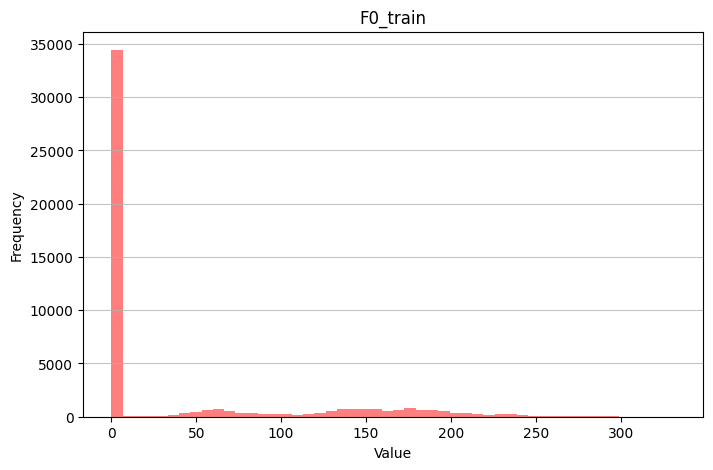

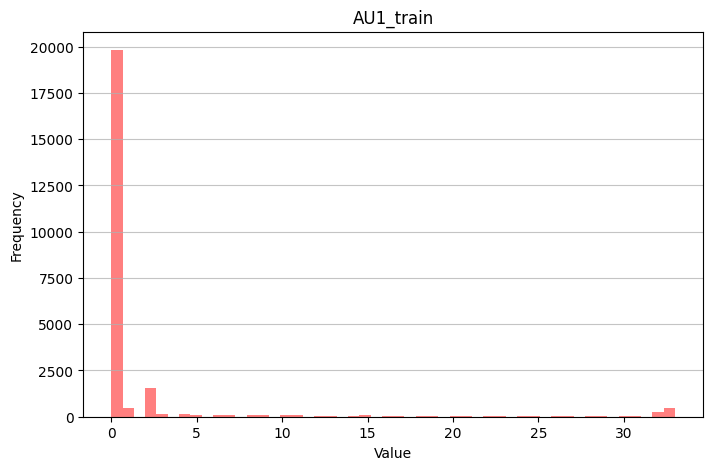

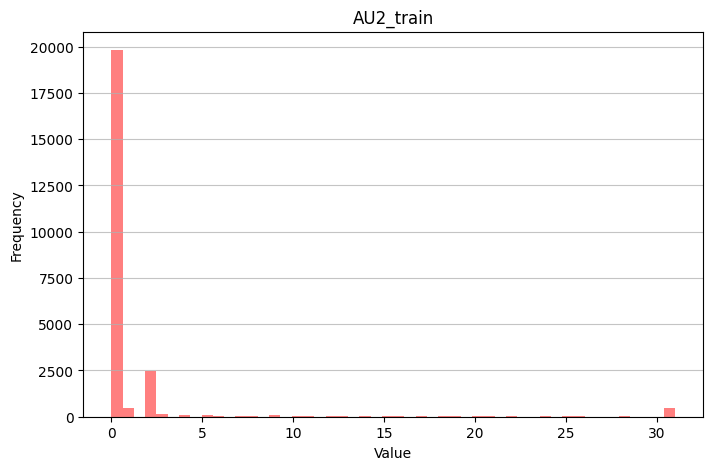

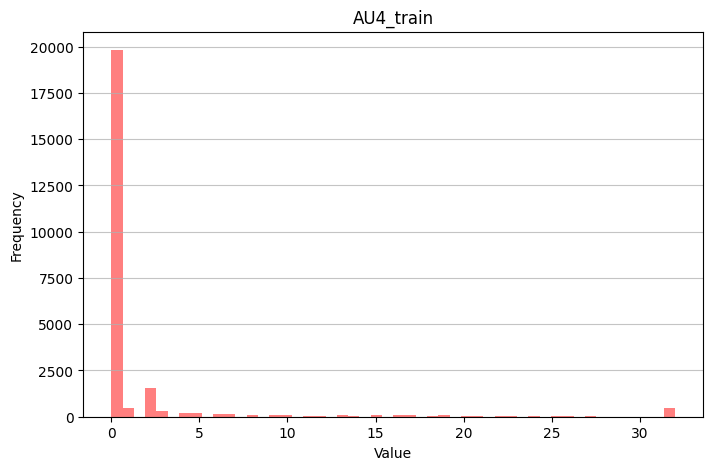

In [5]:
from matplotlib import pyplot as plt
# plot the data
def plot_distribution(data, title):
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=50, alpha=0.5, color='red')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

plot_distribution(F0_train.flatten(), "F0_train")
plot_distribution(au_train[:,0,:].flatten(), "AU1_train")
plot_distribution(au_train[:,1,:].flatten(), "AU2_train")
plot_distribution(au_train[:,2,:].flatten(), "AU4_train")

### Question 2: Define 3 dataloader for train validation and test

In [6]:
# import packages
from torch.utils.data import Dataset, DataLoader

# data loader define
class CustomDataset(Dataset):
    def __init__(self, f0_data, au_data, f0_mask, au_mask):
        """
        Initialize the dataset
        :param f0_data: F0 data (numpy array)
        :param au_data: AU data (numpy array)
        :param f0_mask: F0 mask (numpy array)
        :param au_mask: AU mask (numpy array)
        """
        self.f0_data = torch.tensor(f0_data)
        self.au_data = torch.tensor(au_data)
        self.f0_mask = torch.tensor(f0_mask)
        self.au_mask = torch.tensor(au_mask)
        
    def __len__(self):
        """
        Return the number of samples
        """
        return len(self.f0_data)
    
    def __getitem__(self, idx):
        """
        Get the data based on the index
        :param idx: Index
        :return: F0 data, AU data, F0 mask, AU mask
        """
        return self.au_data[idx], self.f0_data[idx], self.au_mask[idx], self.f0_mask[idx]

In [7]:
train_dataset = CustomDataset(F0_train, au_train, F0_mask_train, au_mask_train)
validation_dataset = CustomDataset(F0_val, au_val, F0_mask_val, au_mask_val)
test_dataset = CustomDataset(F0_test, au_test, F0_mask_test, au_mask_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Question 3: Define the model, optimizer and loss function

In [8]:
model = AU_predictor(d_model=64 ,nhead=8, num_encoder_layers=4, num_decoder_layers=4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

### Question 4: Train the model and plot the evolution of the training and validation loss (comment)

In [9]:
def train(model, optimizer, criterion,n_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_losses = []
    val_losses = []


    model.train()


    for e in tqdm(range(n_epochs)):
        losstot = 0
        model.train()
        for i, batch in enumerate(train_dataloader):
            AUs, F0, AU_mask, F0_mask = batch
            AUs = AUs.to(device)

            F0 = F0.to(device)
            AU_mask = AU_mask.to(device)
            F0_mask = F0_mask.to(device)
            F0_mask = (F0_mask).bool()
            AU_mask = (AU_mask).bool()
            au1,au2,au4  = model(AUs, F0, AU_mask, F0_mask)

            loss_au1 = criterion(au1.permute(0, 2, 1), AUs[:, 0])
            loss_au2 = criterion(au2.permute(0, 2, 1), AUs[:, 1])
            loss_au4 = criterion(au4.permute(0, 2, 1), AUs[:, 2])

            loss = loss_au1 + loss_au2 + loss_au4

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losstot += loss.item()
        train_losses.append(losstot/(len(train_dataloader)))
        losstot = 0
        model.eval()
        for i, val_batch in enumerate(validation_dataloader):
            AUs, F0, AU_mask, F0_mask = val_batch
            AUs = AUs.to(device)
            F0 = F0.to(device)
            AU_mask = AU_mask.to(device)
            F0_mask = F0_mask.to(device)
            F0_mask = (F0_mask).bool()
            AU_mask = (AU_mask).bool()
            au1,au2,au4  = model(AUs, F0, AU_mask, F0_mask)

            loss_au1 = criterion(au1.permute(0, 2, 1), AUs[:, 0])
            loss_au2 = criterion(au2.permute(0, 2, 1), AUs[:, 1])
            loss_au4 = criterion(au4.permute(0, 2, 1), AUs[:, 2])
            loss = loss_au1 + loss_au2 + loss_au4

            losstot += loss.item()
        val_losses.append(losstot/(len(validation_dataloader)))
    sns.lineplot(train_losses, label="train")
    sns.lineplot(val_losses, label="val")
    return model

100%|██████████| 1000/1000 [09:10<00:00,  1.82it/s]


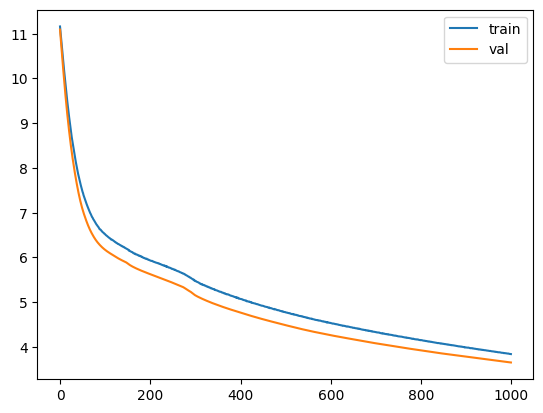

In [10]:
# model = train(d_model=32,nhead=8,num_encoder_layers=4,num_decoder_layers=4,lr=1e-6,n_epochs=1000)
# parameters defined in the beginning of this section
model = train(model, optimizer, criterion, 1000)

In [11]:
# save the model
torch.save(model.state_dict(), "Heyuan_brain.pth")

### Question 5: If necessary change hyperparameters and retrain the model (comment)

100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s]


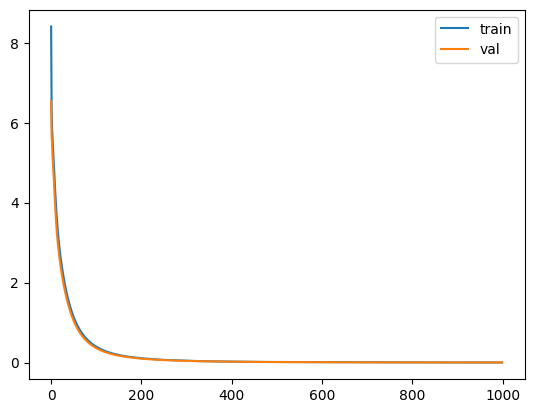

In [12]:
# change the optimizer in learning rates from 1e-6 to 1e-4
model = AU_predictor(d_model=64,nhead=8,num_encoder_layers=4,num_decoder_layers=4)
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model = train(model=model,optimizer=optimizer,criterion=criterion,n_epochs=1000)

### Question 6: Evaluate the model on the test set in inference mode ( using the fonction generate of  AUPredictor) and save your predictions

In [41]:
def test(model):
    pred_AUS = []
    
    for i, batch in enumerate(test_dataloader):
        AUs, F0, AU_mask, F0_mask = batch
        # AUs = AUs.to(device)
        # F0 = F0.to(device)
        # AU_mask = AU_mask.to(device)
        # F0_mask = F0_mask.to(device)
        F0_mask = (F0_mask).bool()
        AU_mask = (AU_mask).bool()
        au1,au2,au4  = model.generate( F0,F0_mask)
        current_output = torch.stack([au1, au2, au4], dim=1)
        if i==0:
            pred_AUS = torch.stack([au1, au2, au4], dim=0)
        else:
            pred_AUS = torch.cat([pred_AUS,torch.stack([au1, au2, au4], dim=0)],dim=1)
    return pred_AUS

In [42]:
# Load the model
model = AU_predictor(d_model=64,nhead=8,num_encoder_layers=4,num_decoder_layers=4)
model.load_state_dict(torch.load("Heyuan_brain.pth"))
model.eval()

pred_AUS = test(model)
print(pred_AUS.shape)
pred_AUS = pred_AUS.cpu().detach().numpy()

# Save the predicted AUs as npy file
np.save("pred_AUS.npy", pred_AUS)

/tmp/ipykernel_1474026/2684054655.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("Heyuan_brain.pth"))


F0 =  tensor([[[ 0.0000,  6.0859,  2.6699,  ...,  1.0000,  5.0080,  2.7946],
         [ 0.8415,  5.5429,  3.3143,  ...,  1.0000,  4.9192,  2.7673],
         [ 0.9093,  4.4791,  3.5807,  ...,  1.0000,  4.8421,  2.7281],
         ...,
         [ 0.1060, -0.7812, -0.6051,  ...,  0.9999,  0.0215,  1.1203],
         [-0.7795, -0.4133,  0.0377,  ...,  0.9999,  0.0217,  1.1203],
         [-0.9483,  0.5306,  0.7474,  ...,  0.9999,  0.0218,  1.1203]]],
       grad_fn=<AddBackward0>)
x =  tensor([[[-1.3800,  2.1645,  0.2892,  ..., -0.9162,  0.0022,  0.2138],
         [-1.3058,  2.1144,  0.3852,  ..., -0.9721,  0.0074,  0.2141],
         [-1.3002,  2.0091,  0.4423,  ..., -1.0096,  0.0304,  0.2170],
         ...,
         [ 0.7189, -0.1281, -0.1645,  ...,  0.2401,  1.1027, -0.6256],
         [-0.2280,  0.2481,  0.3505,  ...,  0.0302,  1.2224, -0.6943],
         [-0.5482,  0.8205,  0.7651,  ...,  0.0114,  1.1254, -0.7229]]],
       grad_fn=<NativeLayerNormBackward0>)
F0 =  tensor([[[ 0.0000, 14.800

# Part 2 Objective evaluation

We consider an AU as “Activated” (AU = 1) when its value is greater than 0.5, otherwise it is “Not-Activated” (AU = 0). The following figure depicts an example:
<img src="activation.png">
### Question 7 : Compute the activation of your predictions on the testing set and plot the activation of the first word of the testing set

In [43]:
def plot_activation(au_gt, au_pred, title):
    plt.figure(figsize=(6, 4))
    plt.plot(au_gt, label='Ground Truth', color='blue')
    plt.plot(au_pred, label='Predicted', color='orange')
    plt.title(title)
    plt.legend()
    plt.show()
    
    au_activate = [0 if au < 0.5 else 1 for au in au_pred]
    plt.figure(figsize=(5, 2))
    plt.plot(au_activate, color='pink')
    plt.ylabel('Activation')
    plt.ylim(-0.1, 1.1)
    plt.title(title)
    plt.show()

In [44]:
# pred_AUS.shape
AUs, F0, AU_mask, F0_mask = test_dataset[i_sample]
AUs.shape

torch.Size([3, 50])

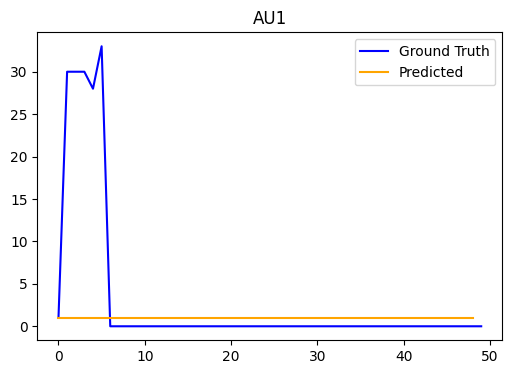

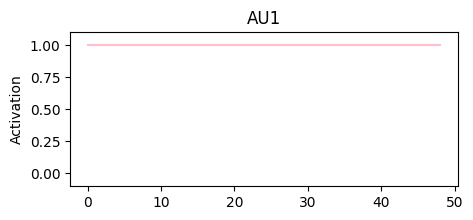

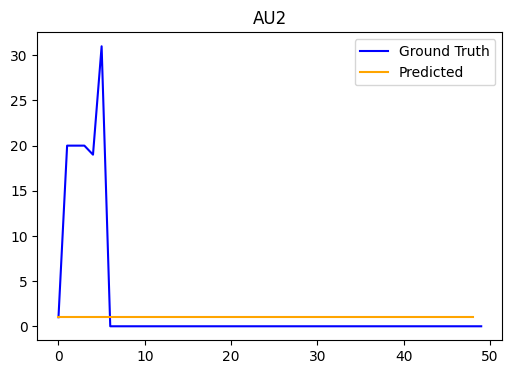

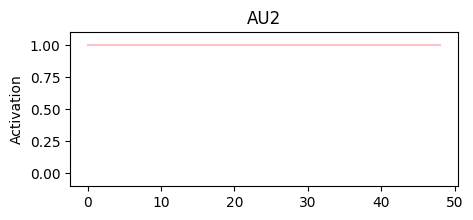

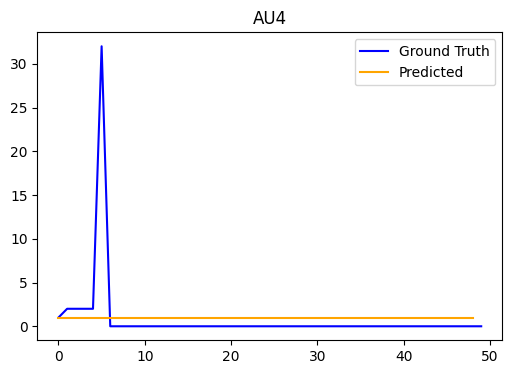

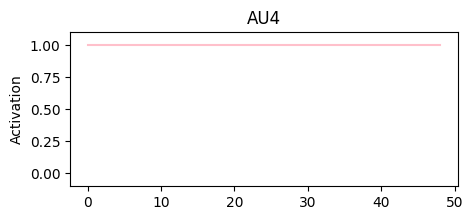

In [45]:
i_sample = 0


au1 = AUs[0].numpy()
au2 = AUs[1].numpy()
au4 = AUs[2].numpy()

au1_prediction = pred_AUS[i_sample, 0]
au2_prediction = pred_AUS[i_sample, 1]
au4_prediction = pred_AUS[i_sample, 2]

plot_activation(au1, au1_prediction, 'AU1')
plot_activation(au2, au2_prediction, 'AU2')
plot_activation(au4, au4_prediction, 'AU4')

### Question 7: For the training and test set, generate different plots of activated action units to illustrate predicted sequences Vs. their corresponding ground truth sequences, for each Action Unit.
Do NOT plot Start, End, and Padding tokens


F0 =  tensor([[[ 0.0000e+00,  2.3424e+01,  1.1756e+01,  ...,  1.0000e+00,
           2.2859e+01,  9.3086e+00],
         [ 8.4147e-01,  2.3177e+01,  1.2574e+01,  ...,  1.0000e+00,
           2.3075e+01,  9.3812e+00],
         [ 9.0930e-01,  2.2368e+01,  1.2961e+01,  ...,  1.0000e+00,
           2.3261e+01,  9.4715e+00],
         ...,
         [ 1.0599e-01, -7.8118e-01, -6.0514e-01,  ...,  9.9987e-01,
           2.1520e-02,  1.1203e+00],
         [-7.7947e-01, -4.1326e-01,  3.7745e-02,  ...,  9.9987e-01,
           2.1654e-02,  1.1203e+00],
         [-9.4828e-01,  5.3062e-01,  7.4739e-01,  ...,  9.9986e-01,
           2.1787e-02,  1.1203e+00]]], grad_fn=<AddBackward0>)
x =  tensor([[[ 1.6418e-02,  1.3354e+00,  2.2704e-01,  ..., -3.4917e-01,
           2.3638e-01,  2.6910e-01],
         [ 2.8925e-02,  1.3250e+00,  2.5594e-01,  ..., -3.7196e-01,
           2.3077e-01,  2.6821e-01],
         [ 7.3251e-03,  1.3059e+00,  2.7573e-01,  ..., -4.0565e-01,
           2.2563e-01,  2.6946e-01],
    

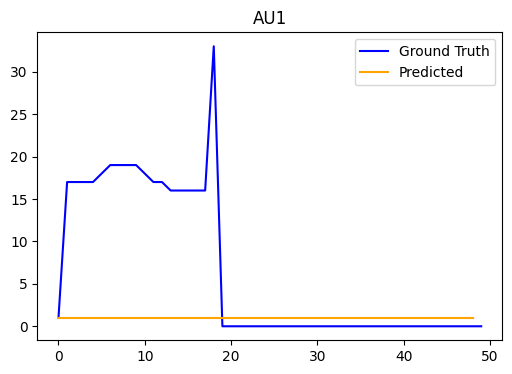

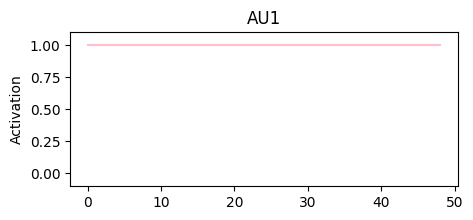

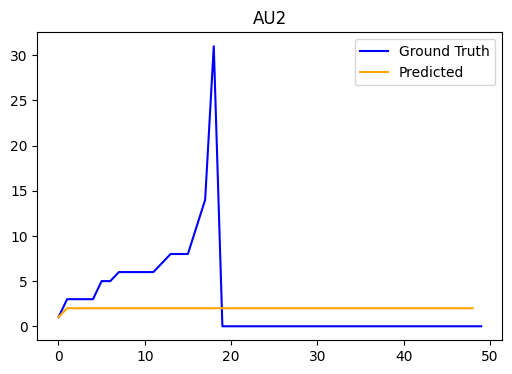

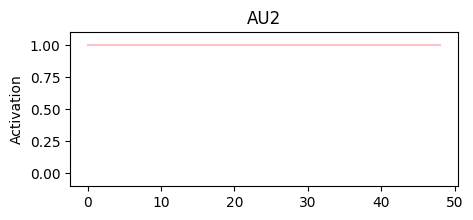

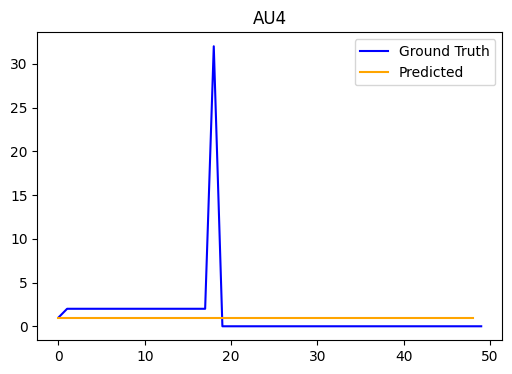

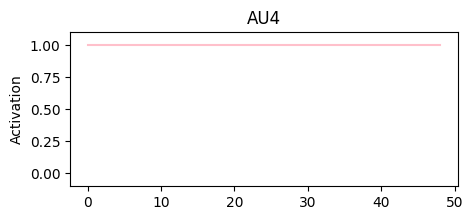

In [46]:
# plot on the train dataset
AUs, F0, AU_mask, F0_mask = train_dataset[0]
AUs = AUs.unsqueeze(0)
F0 = F0.unsqueeze(0)
AU_mask = AU_mask.unsqueeze(0)
F0_mask = F0_mask.unsqueeze(0)
F0_mask = (F0_mask).bool()
AU_mask = (AU_mask).bool()
au1,au2,au4  = model.generate( F0,F0_mask)
pred_AUS = torch.stack([au1, au2, au4], dim=0)
pred_AUS = pred_AUS.permute(1, 0, 2)[0].cpu().detach().numpy()

AUs = AUs.squeeze(0).cpu().detach().numpy()
au1 = AUs[0]
au2 = AUs[1]
au4 = AUs[2]

au1_prediction = pred_AUS[0]
au2_prediction = pred_AUS[1]
au4_prediction = pred_AUS[2]

plot_activation(au1, au1_prediction, 'AU1')
plot_activation(au2, au2_prediction, 'AU2')
plot_activation(au4, au4_prediction, 'AU4')

### Question 8 : To assess the quality of the generated gestures, apply the following measures on the test set:

Root Mean Squared Error (RMSE)
Pearson Correlation Coefficient (PCC)
Activity Hit Ratio (AHR):  the percentage of predicted AU activation with respect to the AU activation in ground truth.
Non-Activity Hit Ratio (NAHR): the percentage of predicted AU non-activation with respect to AU non-activation in ground truth.


In [65]:
import scipy.stats
def remove_special_tokens(sequence):
    mask = (sequence != AU_beg) & (sequence != AU_end) & (sequence != AU_pad)
    return mask

def compute_rmse(pred, true):
    pred = pred.numpy()
    mse = np.mean((pred - true) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def compute_pcc(pred, true):
    pred = pred.numpy()
    if np.all(pred == pred[0]) or np.all(true == true[0]):
        return 0
    pcc, _ = scipy.stats.pearsonr(pred, true)
    return pcc

def compute_ahr(pred_activated, true_activated):
    
    activated_mask = (true_activated == 1)
    correct_activations = (pred_activated[activated_mask] == 1).sum()
    total_activations = activated_mask.sum()
    ahr = correct_activations / total_activations
    return ahr

def compute_nahr(pred_activated, true_activated):
    non_activated_mask = (true_activated == 0)
    correct_non_activations = (pred_activated[non_activated_mask] == 0).sum()
    total_non_activations = non_activated_mask.sum()
    if total_non_activations == 0:
        return 0
    nahr = correct_non_activations / total_non_activations
    return nahr

In [51]:
pred_AUS = test(model)
print("pred_AUS shape:", pred_AUS.shape)  # 期望形状: (num_samples, 3, feature_dim)

F0 =  tensor([[[ 0.0000,  6.0859,  2.6699,  ...,  1.0000,  5.0080,  2.7946],
         [ 0.8415,  5.5429,  3.3143,  ...,  1.0000,  4.9192,  2.7673],
         [ 0.9093,  4.4791,  3.5807,  ...,  1.0000,  4.8421,  2.7281],
         ...,
         [ 0.1060, -0.7812, -0.6051,  ...,  0.9999,  0.0215,  1.1203],
         [-0.7795, -0.4133,  0.0377,  ...,  0.9999,  0.0217,  1.1203],
         [-0.9483,  0.5306,  0.7474,  ...,  0.9999,  0.0218,  1.1203]]],
       grad_fn=<AddBackward0>)
x =  tensor([[[-1.3800,  2.1645,  0.2892,  ..., -0.9162,  0.0022,  0.2138],
         [-1.3058,  2.1144,  0.3852,  ..., -0.9721,  0.0074,  0.2141],
         [-1.3002,  2.0091,  0.4423,  ..., -1.0096,  0.0304,  0.2170],
         ...,
         [ 0.7189, -0.1281, -0.1645,  ...,  0.2401,  1.1027, -0.6256],
         [-0.2280,  0.2481,  0.3505,  ...,  0.0302,  1.2224, -0.6943],
         [-0.5482,  0.8205,  0.7651,  ...,  0.0114,  1.1254, -0.7229]]],
       grad_fn=<NativeLayerNormBackward0>)
F0 =  tensor([[[ 0.0000, 14.800

In [58]:
print("pred_AUS shape before permute:", pred_AUS.shape)
pred_AUS = pred_AUS.permute(1, 0, 2) 
print("pred_AUS shape after permute:", pred_AUS.shape)
pred_AUS.shape

pred_AUS shape before permute: torch.Size([3, 61, 49])
pred_AUS shape after permute: torch.Size([61, 3, 49])


torch.Size([61, 3, 49])

In [66]:
RMSEs = [[], [], []]
PCCs = [[], [], []]
AHRs = [[], [], []]
NAHRs = [[], [], []]

for i in range(len(test_dataset)):
    AUs, F0, AU_mask, F0_mask = test_dataset[i]
    
    for j in range(3):
        au = AUs[j].numpy()
        au_prediction = pred_AUS[i, j]
        mask = remove_special_tokens(au)
        au = au[mask]
        au_prediction = au_prediction[mask[:-1]]
        if len(au) < 2:
            continue
        au_pred_activated = (au_prediction.numpy() > 0.5).astype(np.int32)
        au_true_activated = (au > 0.5).astype(np.int32)

        rmse = compute_rmse(au_prediction, au)
        pcc = compute_pcc(au_prediction, au)
        ahr = compute_ahr(au_pred_activated, au_true_activated)
        nahr = compute_nahr(au_pred_activated, au_true_activated)
        
        RMSEs[j].append(rmse)
        PCCs[j].append(pcc)
        AHRs[j].append(ahr)
        NAHRs[j].append(nahr)

print("AU1 RMSE:", np.mean(RMSEs[0]))
print("AU1 PCC:", np.mean(PCCs[0]))
print("AU1 AHR:", np.mean(AHRs[0]))
print("AU1 NAHR:", np.mean(NAHRs[0]))
print()
print("AU2 RMSE:", np.mean(RMSEs[1]))
print("AU2 PCC:", np.mean(PCCs[1]))
print("AU2 AHR:", np.mean(AHRs[1]))
print("AU2 NAHR:", np.mean(NAHRs[1]))
print()
print("AU4 RMSE:", np.mean(RMSEs[2]))
print("AU4 PCC:", np.mean(PCCs[2]))
print("AU4 AHR:", np.mean(AHRs[2]))
print("AU4 NAHR:", np.mean(NAHRs[2]))
    

AU1 RMSE: 10.757588907697308
AU1 PCC: 0.0
AU1 AHR: 1.0
AU1 NAHR: 0.0

AU2 RMSE: 13.17076782892581
AU2 PCC: 0.0
AU2 AHR: 0.9180327868852459
AU2 NAHR: 0.0

AU4 RMSE: 14.487316630194567
AU4 PCC: -0.007558330720510927
AU4 AHR: 0.9739398659842248
AU4 NAHR: 0.0


### Question 9 : Plot and explain each of the metrics.

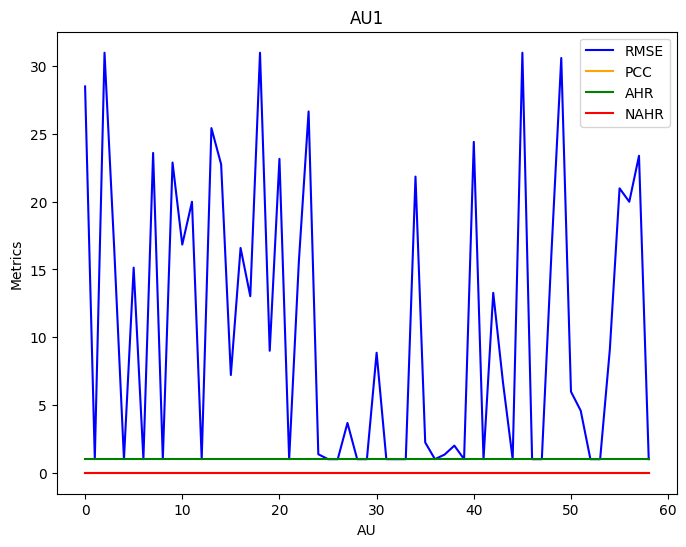

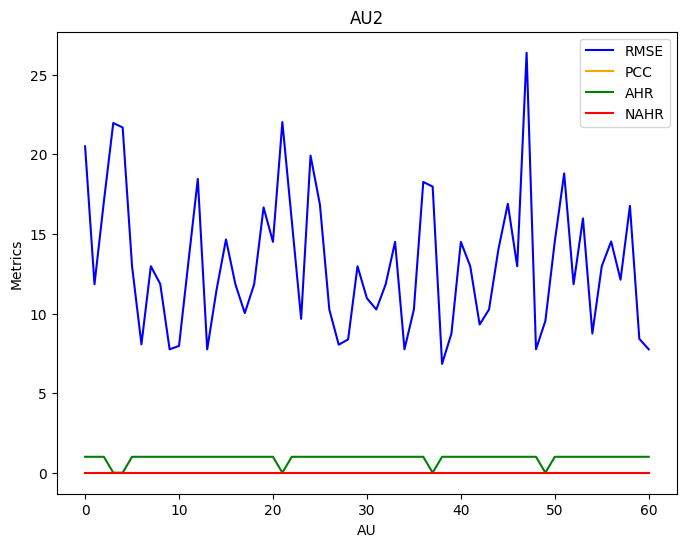

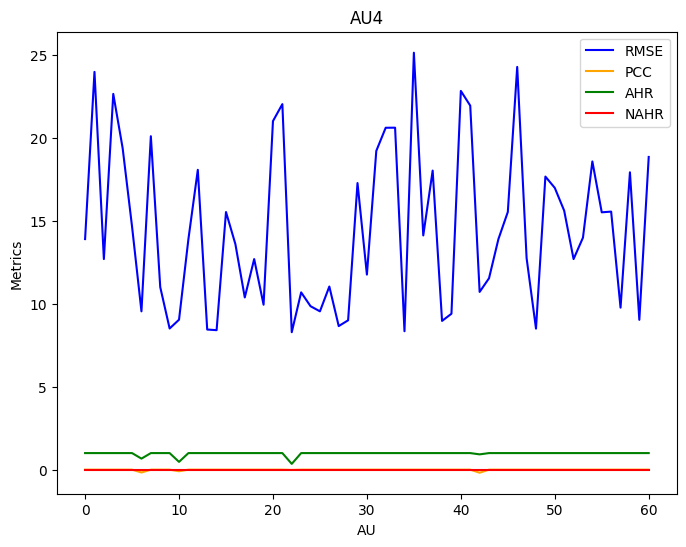

In [70]:
# plot the results of AU1, AU2, AU4
def plot_results(RMSEs, PCCs, AHRs, NAHRs, title):
    plt.figure(figsize=(8, 6))
    plt.plot(RMSEs, label='RMSE', color='blue')
    plt.plot(PCCs, label='PCC', color='orange')
    plt.plot(AHRs, label='AHR', color='green')
    plt.plot(NAHRs, label='NAHR', color='red')
    plt.title(title)
    plt.xlabel('AU')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

plot_results(RMSEs[0], PCCs[0], AHRs[0], NAHRs[0], 'AU1')
plot_results(RMSEs[1], PCCs[1], AHRs[1], NAHRs[1], 'AU2')
plot_results(RMSEs[2], PCCs[2], AHRs[2], NAHRs[2], 'AU4')


### Question 10 :  Comment your objective evaluation results.